<a href="https://colab.research.google.com/github/stoiver/anuga-clinic-2018/blob/master/notebooks/notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSDMS ANUGA Clinic 2018

## Notebook 5: Monai Valley Tsunami runup 

Validation of the AnuGA implementation of the shallow water wave equation.
This script sets up Okushiri Island benchmark as published at the

The Third International Workshop on Long-Wave Runup Models
June 17-18 2004

Wrigley Marine Science Center
Catalina Island, California
http://www.cee.cornell.edu/longwave/


The validation data was downloaded and made available in this directory
for convenience but the original data is available at
http://www.cee.cornell.edu/longwave/index.cfm?page=benchmark&problem=2
where a detailed description of the problem is also available.


### Installation

These notebooks have been designed to run in the google `colaboratory` environment, which provides a jupyter notebook environment running on a virtual machine on the cloud. To use this environment you need a google account so that your notebook can be saved on google drive. 

If on github, first follow the link `View in Colaboratory' to start running on google's colab environment. 

Then run the following cell to install the dependencies and some extra code for visualising on Colaboratory.

Wait until you see the comment *(5) Ready to go* before proceeding to subsequent commands. 

The install should take less than a minute (and quicker if you have already run this earlier).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

try:
  # On colab we can install all the packages we need via the notebook
  #
  # First download the clinic repository
  import os
  os.chdir('/content')
  !git clone https://github.com/stoiver/anuga-clinic-2018.git

  # Now install environment using tool
  !/bin/bash /content/anuga-clinic-2018/anuga_tools/install_anuga_colab.sh
 
except:
  pass

# Make inline animate code available
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()

import sys
sys.path.append(os.path.join(workbookDir,"anuga-clinic-2018"))


%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

fatal: destination path 'anuga-clinic-2018' already exists and is not an empty directory.
(1) Install netcdf nose via pip
(2) Install gdal via apt-get
(3) Download anuga_core github repository
(4) Install anuga
(5) Ready to go


### Import ANUGA and Tools

The `anuga` and `anuga_clinic-2018` packages have been installed we can now `import` our standard libraries.

In [0]:
import anuga
import anuga_tools.animate as animate

## The Code 

This code is taken from `anuga_core/validation_tests/experimental_data/okishuri/run_okishuri.py`.

First we define the location of our data files, which specify:

   (1) the incoming tsunami wave, 
   
   (2) the bathymetry file, 
   
   (3) the measured stage height at 3 gauge locations.


In [0]:
# Incoming boundary wave
boundary_filename = '/content/anuga-clinic-2018/data/Okushiri/Benchmark_2_input.txt'

# Digital Elevation Model
bathymetry_filename = '/content/anuga-clinic-2018/data/Okushiri/Benchmark_2_Bathymetry.xya'

# Observed timeseries
gauge_filename = '/content/anuga-clinic-2018/data/Okushiri/output_ch5-7-9.txt'



### Load Barthymetry Data

Using in the barthymetry data provided from the workshop. We need to reshape the data and form a raster (x,y,Z).

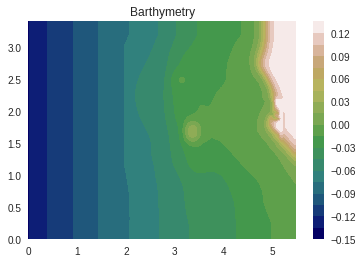

In [4]:
xya = np.loadtxt(bathymetry_filename, skiprows=1, delimiter=',')
  
X = xya[:,0].reshape(393,244)
Y = xya[:,1].reshape(393,244)
Z = xya[:,2].reshape(393,244)


plt.contourf(X,Y,Z, 20, cmap=plt.get_cmap('gist_earth'));
plt.title('Barthymetry')
plt.colorbar();

# Create raster tuple
x = X[:,0]
y = Y[0,:]
Zr = np.flipud(Z.T)

raster = x,y,Zr

### Load Incoming Wave 

We will apply an incoming wave on the left boundary. So first we load the data from the `boundary_filename` file. 

From the data we form an interpolation functon called  `wave_function`, which will be used to specify the boundary condition on the left. 

And we also plot the function.  The units of the data in the file are metres, and the scale of the experimental setup is 1 in 400. 

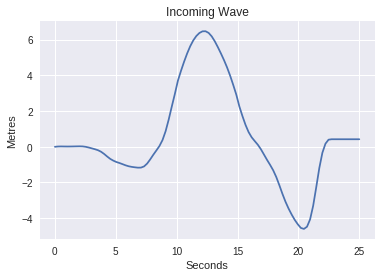

In [5]:
bdry = np.loadtxt(boundary_filename, skiprows=1)

bdry_t = bdry[:,0]
bdry_v = bdry[:,1]


import scipy
wave_function = scipy.interpolate.interp1d(bdry_t, bdry_v, kind='zero', fill_value='extrapolate')

t = np.linspace(0.0,25.0, 100)

plt.plot(t,wave_function(t)*400);
plt.xlabel('Seconds')
plt.ylabel('Metres')
plt.title('Incoming Wave');

## Setup Domain

We define the `domain` for our simulation. This object encapsulates the mesh for our problem, which is defined by setting up a bounding polygon and associated tagged boundary. We use the `base_resolution` variable to set the maximum area of the triangles of our mesh.  

At the end we use `matplotlib` to visualise the mesh associated with the `domain`.



Number of Elements  2884
Figure files for each frame will be stored in _plot


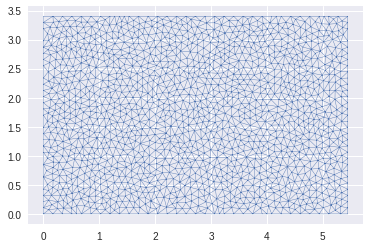

In [6]:
base_resolution = 0.01
#base_resolution = 0.0005

# Basic geometry and bounding polygon
xleft   = 0
xright  = 5.448
ybottom = 0
ytop    = 3.402

point_sw = [xleft, ybottom]
point_se = [xright, ybottom]
point_nw = [xleft, ytop]    
point_ne = [xright, ytop]

bounding_polygon = [point_se,
                    point_ne,
                    point_nw,
                    point_sw]

domain = anuga.create_domain_from_regions(bounding_polygon,
                                 boundary_tags={'wall': [0, 1, 3],
                                                'wave': [2]},     
                                 maximum_triangle_area=base_resolution,
                                 use_cache=False,
                                 verbose=False)


domain.set_name('okushiri')  # Name of output sww file 
domain.set_minimum_storable_height(0.001) # Don't store w-z < 0.001m
domain.set_flow_algorithm('DE1')

print 'Number of Elements ', domain.number_of_elements

dplotter = animate.Domain_plotter(domain, min_depth=0.001)  
plt.triplot(dplotter.triang, linewidth = 0.4);

### Setup Quantities

We use the `raster` created earlier to set the `quantity` called `elevation`.  We also set the  `stage` and the Mannings `friction`. 

We also visualise the `elevation` quantity. 


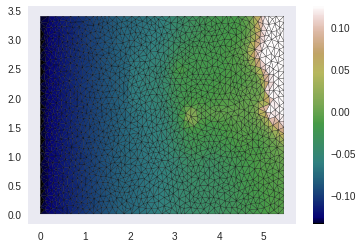

In [7]:
domain.set_quantity('elevation',raster=raster, location='centroids')
domain.set_quantity('stage', 0.0)
domain.set_quantity('friction', 0.0025)


plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              edgecolors='k', 
              cmap='gist_earth')
plt.colorbar();

### Setup Boundary Conditions

Excuse the verbose boundary type name `Transmissive_n_momentum_zero_t_momentum_set_stage_boundary`, but we use that to set the incoming wave boundary condition. 

On the other boundaries we will have just reflective boundaries.

In [0]:
Bts = anuga.Transmissive_n_momentum_zero_t_momentum_set_stage_boundary(domain, wave_function)

Br = anuga.Reflective_boundary(domain)

domain.set_boundary({'wave': Bts, 'wall': Br})

### Setup Interogation Variables

We will record the stage at the 3 gauge locations and at the Monai valley. 

In [0]:
yieldstep = 0.5
finaltime = 22.5

nt = int(finaltime/yieldstep)+1


# area for gulleys
x1 = 4.85
x2 = 5.25
y1 = 2.05
y2 = 1.85

# indices in gulley area
x = domain.centroid_coordinates[:,0]
y = domain.centroid_coordinates[:,1]
v = np.sqrt( (x-x1)**2 + (y-y1)**2 ) + np.sqrt( (x-x2)**2 + (y-y2)**2 ) < 0.5


# Gauge and bounday locations
gauge = [[4.521, 1.196],  [4.521, 1.696],  [4.521, 2.196]] #Ch 5-7-9
bdyloc = [0.00001, 2.5]
g5_id = domain.get_triangle_containing_point(gauge[0])
g7_id = domain.get_triangle_containing_point(gauge[1])
g9_id = domain.get_triangle_containing_point(gauge[2])
bc_id = domain.get_triangle_containing_point(bdyloc)

# Arrays to store data
meanstage = np.nan*np.ones((nt,))
g5 = np.nan*np.ones((nt,))
g7 = np.nan*np.ones((nt,))
g9 = np.nan*np.ones((nt,))
bc = np.nan*np.ones((nt,))

### Evolve

In [10]:
Stage = domain.quantities['stage'].centroid_values
stage_qoi = Stage[v]

k = 0
for t in domain.evolve(yieldstep=yieldstep, finaltime=finaltime):

    domain.print_timestepping_statistics()
    
    # stage
    stage_qoi = Stage[v]
    meanstage[k] = np.mean(stage_qoi)
    g5[k] = Stage[g5_id]
    g7[k] = Stage[g7_id]
    g9[k] = Stage[g9_id]
    
    k = k+1
     
    #dplotter.save_depth_frame()


# Read in the png files stored during the evolve loop
#dplotter.make_depth_animation()

Time = 0.0000, steps=0 (14s)
Time = 0.5000, delta t in [0.01553114, 0.01553127], steps=33 (0s)
Time = 1.0000, delta t in [0.01552392, 0.01553122], steps=33 (0s)
Time = 1.5000, delta t in [0.01552381, 0.01552585], steps=33 (0s)
Time = 2.0000, delta t in [0.01552456, 0.01552599], steps=33 (0s)
Time = 2.5000, delta t in [0.01552109, 0.01552454], steps=33 (0s)
Time = 3.0000, delta t in [0.01552098, 0.01553040], steps=33 (0s)
Time = 3.5000, delta t in [0.01551921, 0.01553066], steps=33 (0s)
Time = 4.0000, delta t in [0.01550540, 0.01551913], steps=33 (0s)
Time = 4.5000, delta t in [0.01548068, 0.01550529], steps=33 (0s)
Time = 5.0000, delta t in [0.01544420, 0.01548039], steps=33 (0s)
Time = 5.5000, delta t in [0.01542374, 0.01544386], steps=33 (0s)
Time = 6.0000, delta t in [0.01541583, 0.01542361], steps=33 (0s)
Time = 6.5000, delta t in [0.01540816, 0.01541572], steps=33 (0s)
Time = 7.0000, delta t in [0.01540731, 0.01540954], steps=33 (0s)
Time = 7.5000, delta t in [0.01540962, 0.015417

### Animation Using swwfile

Read in the sww file and then iterate through the time slices to produce an animation.

In [16]:
swwplotter = animate.SWW_plotter('okushiri.sww', min_depth = 0.001)

n = len(swwplotter.time)

for k in range(n):
  swwplotter.save_depth_frame(k)
  print swwplotter.time[k],
  
  if k%10 == 0:
      print ' '
  
swwplotter.make_depth_animation()

 Figure files for each frame will be stored in _plot
46
0.0  
0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0  
5.5 6.0 6.5 7.0 7.5 8.0 8.5 9.0 9.5 10.0  
10.5 11.0 11.5 12.0 12.5 13.0 13.5 14.0 14.5 15.0  
15.5 16.0 16.5 17.0 17.5 18.0 18.5 19.0 19.5 20.0  
20.5 21.0 21.5 22.0 22.5

### View Time  Series

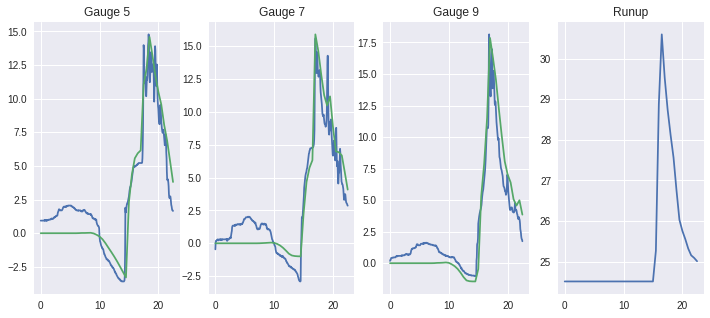

In [17]:
old_figsize = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = [12, 5]

gauge = np.loadtxt(gauge_filename, skiprows=1)

gauge_t = gauge[:,0]
gauge_5 = gauge[:,1]
gauge_7 = gauge[:,2]
gauge_9 = gauge[:,3]

nt = int(finaltime/yieldstep)+1

import scipy
gauge_5_f = scipy.interpolate.interp1d(gauge_t, gauge_5, kind='zero', fill_value='extrapolate')
gauge_7_f = scipy.interpolate.interp1d(gauge_t, gauge_7, kind='zero', fill_value='extrapolate')
gauge_9_f = scipy.interpolate.interp1d(gauge_t, gauge_9, kind='zero', fill_value='extrapolate')

t = np.linspace(0.0,22.5, 451)

tt= np.linspace(0.0,22.5, nt)

plt.subplot(1,4,1)
plt.plot(t,gauge_5_f(t)*4)
plt.plot(tt,g5*400)
plt.title('Gauge 5')

plt.subplot(1,4,2)
plt.plot(t,gauge_7_f(t)*4)
plt.plot(tt,g7*400)
plt.title('Gauge 7')

plt.subplot(1,4,3)
plt.plot(t,gauge_9_f(t)*4)
plt.plot(tt,g9*400)
plt.title('Gauge 9')
         
plt.subplot(1,4,4)
plt.plot(tt,meanstage*400)
plt.title('Runup');
         

plt.rcParams['figure.figsize'] = old_figsize